# Patching the Cross Validation Performance of Various Feature Sets v5


In [1]:
print("START")

START


In [2]:
from sklearn import tree
from sklearn.metrics import balanced_accuracy_score

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import copy

from tqdm.notebook import tqdm

from src.helpers.helpers_predator.common import load_predator
from src.Benchmark.RivalStudies.PROVEAN.utils import BaselineProveanClassifier
from src.Benchmark.RivalStudies.ELASPIC_ddG.utils import BaselineDeltaDeltaGClassifier


import os

os.chdir("../")

# Reflect changes in the modules immediately.
%load_ext autoreload
%autoreload 2

In [3]:
PREDATOR_PATH = "PredatorModels/PredatorModel_2022-06-16/cc84a54e/predator.pkl"

In [4]:
predator = load_predator(PREDATOR_PATH)

2022-06-20 14:45:32 | INFO     | src.helpers.helpers_predator.common | Predator object PredatorModels/PredatorModel_2022-06-16/cc84a54e/predator.pkl is loaded successfully.


In [5]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'sampled_train_data_list', 'prepared_dataframes', 'label_proportions_dataframes', 'Xs', 'ys', 'Xs_train', 'ys_train', 'Xs_valid', 'ys_valid', 'Xs_train_random', 'ys_train_random', 'Xs_valid_random', 'ys_valid_random', 'Xs_shap_5', 'Xs_train_shap_5', 'Xs_valid_shap_5', 'Xs_provean', 'Xs_train_provean', 'Xs_ddG', 'Xs_train_ddG', 'Xs_shap_10', 'Xs_train_shap_10', 'Xs_valid_shap_10', 'Xs_shap_20', 'Xs_train_shap_20', 'Xs_valid_shap_20', 'Xs_shap_30', 'Xs_train_shap_30', 'Xs_valid_shap_30', 'Xs_shap_40', 'Xs_train_shap_40', 'Xs_valid_shap_40'])

In [10]:
Xs_ddG_example = copy.deepcopy(predator.data_materials["Xs_ddG"])
Xs_provean_example = copy.deepcopy(predator.data_materials["Xs_provean"])
ys_example = copy.deepcopy(predator.data_materials["ys"])

In [7]:
def get_decision_tree_threshold_val(clf_param):
    text_representation = tree.export_text(clf_param)
    thr_val = float(text_representation.split("\n")[0].split()[-1])
    return thr_val

In [8]:
from sklearn.tree import DecisionTreeClassifier

class BaselineAdaptiveThresholdClassifier(DecisionTreeClassifier):
    """
    Uses the threshold value that separates the data instances best.
    """

    MAX_DEPTH = 1

    def __init__(self, max_depth=MAX_DEPTH):
        self.max_depth = max_depth
        super().__init__(max_depth=max_depth)

In [9]:
foo = DecisionTreeClassifier()
foo.criterion

'gini'

In [11]:
clf = BaselineAdaptiveThresholdClassifier()
clf.fit(Xs_ddG_example[0][:132], ys_example[0][:132])
clf.predict(Xs_ddG_example[0][132:])

array([0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1], dtype=int64)

In [12]:
balanced_accuracy_score(ys_example[0][132:], clf.predict(Xs_ddG_example[0][132:]))

0.699134199134199

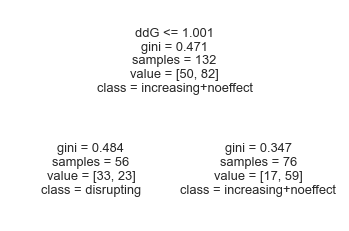

In [13]:
fig = plt.figure()
_ = tree.plot_tree(clf, feature_names=["ddG"], class_names=["disrupting", "increasing+noeffect"])

In [14]:
get_decision_tree_threshold_val(clf)

1.0

In [15]:
X_ddG_sample = Xs_ddG_example[0]
X_provean_sample = Xs_provean_example[0]
y_sample = ys_example[0]

In [16]:
clf = BaselineProveanClassifier()
clf.fit(None, None)
pred = clf.predict(X_provean_sample)
pd.DataFrame(pred).value_counts()

1    144
0     20
dtype: int64

In [17]:
clf = BaselineDeltaDeltaGClassifier()
clf.fit(None, None)
pred = clf.predict(X_ddG_sample)
pd.DataFrame(pred).value_counts()

1    149
0     15
dtype: int64

In [18]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X_ddG_sample, y_sample)
print(clf.tree_.max_depth)

1


In [19]:
clf.classes_

array([0, 1], dtype=int64)

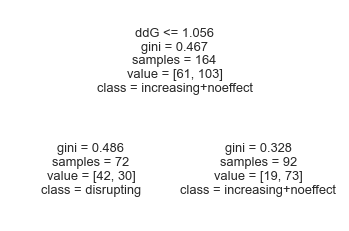

In [20]:
plt.figure()
_ = tree.plot_tree(clf, feature_names=["ddG"], class_names=["disrupting", "increasing+noeffect"])

In [21]:
get_decision_tree_threshold_val(clf)

1.06

5


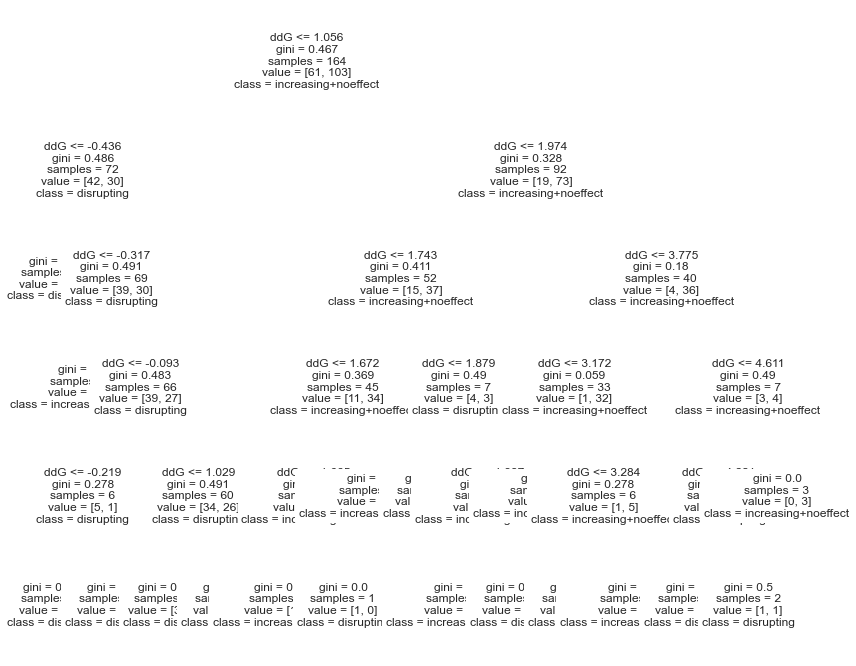

In [22]:
clf_deeper = DecisionTreeClassifier(max_depth=5)
clf_deeper = clf_deeper.fit(X_ddG_sample, y_sample)
print(clf_deeper.tree_.max_depth)
plt.figure(figsize=(14, 12))
tree.plot_tree(clf_deeper, feature_names=["ddG"], class_names=["disrupting", "increasing+noeffect"], fontsize=12);

In [23]:
from src.helpers.helpers_predator.evaluation import cross_val_score_feature_comparison

In [24]:
cross_val_score_feature_comparison(
    X=X_provean_sample,
    y=y_sample,
    scoring="balanced_accuracy",
    n_repeats=5,
    n_jobs=-2,
    clf=BaselineProveanClassifier()
)

0.6234

In [25]:
cross_val_score_feature_comparison(
    X=X_ddG_sample,
    y=y_sample,
    scoring="balanced_accuracy",
    n_repeats=5,
    n_jobs=-2,
    clf=BaselineDeltaDeltaGClassifier()
)

0.5577

In [26]:
cross_val_score_feature_comparison(
    X=X_ddG_sample,
    y=y_sample,
    scoring="balanced_accuracy",
    n_repeats=5,
    n_jobs=-2,
    clf=BaselineAdaptiveThresholdClassifier()
)

0.6602

In [27]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

mcc = make_scorer(matthews_corrcoef)

EVAL_METRICS_DICT = {
    "F1": "f1",
    "BALANCED_ACCURACY": "balanced_accuracy",
    "ACCURACY": "accuracy",
    "F1_MACRO": "f1_macro",
    "F1_MICRO": "f1_micro",
    "PRECISION": "precision",
    "RECALL": "recall",
    "ROC_AUC": "roc_auc",
    "PRECISION_MACRO": "precision_macro",
    "PRECISION_MICRO": "precision_micro",
    # Custom metrics
    "MCC": mcc,
}

In [28]:
for metric_name, metric in EVAL_METRICS_DICT.items():
    print(f"{metric_name} - {metric}")

F1 - f1
BALANCED_ACCURACY - balanced_accuracy
ACCURACY - accuracy
F1_MACRO - f1_macro
F1_MICRO - f1_micro
PRECISION - precision
RECALL - recall
ROC_AUC - roc_auc
PRECISION_MACRO - precision_macro
PRECISION_MICRO - precision_micro
MCC - make_scorer(matthews_corrcoef)


In [29]:
N_JOBS = -2
N_REPEAT = 5

In [30]:
from collections import defaultdict

In [35]:
# Fixed thresholds only, but more evaluation metrics.
def benchmark_single_features(data_materials):
    Xs_train_ddG = copy.deepcopy(data_materials["Xs_train_ddG"])
    Xs_train_provean = copy.deepcopy(data_materials["Xs_train_provean"])
    ys_train = copy.deepcopy(data_materials["ys_train"])

    print(f"{len(Xs_train_ddG)=}")
    print(f"{len(Xs_train_provean)=}")
    print(f"{len(ys_train)=}")

    print(f"{len(Xs_train_ddG[0])=}")
    print(f"{len(Xs_train_provean[0])=}")

    ddg_scoring_metrics = defaultdict(list)
    provean_scoring_metrics = defaultdict(list)

    for X_ddg, X_provean, y in tqdm(zip(Xs_train_ddG, Xs_train_provean, ys_train), total=len(ys_train)):

        for metric_name, metric in EVAL_METRICS_DICT.items():

            if metric_name == "ROC_AUC":
                continue

            # ddG scoring values
            ddg_scores = cross_val_score_feature_comparison(
                X=X_ddg,
                y=y,
                scoring=metric,
                n_repeats=N_REPEAT,
                n_jobs=N_JOBS,
                clf=BaselineDeltaDeltaGClassifier()
            )

            ddg_scoring_metrics[metric_name].append(ddg_scores)

            # Provean scoring values
            provean_scores = cross_val_score_feature_comparison(
                X=X_provean,
                y=y,
                scoring=metric,
                n_repeats=N_REPEAT,
                n_jobs=N_JOBS,
                clf=BaselineProveanClassifier()
            )

            provean_scoring_metrics[metric_name].append(provean_scores)

    return ddg_scoring_metrics, provean_scoring_metrics


In [36]:
obtained_ddg_scoring_metrics, obtained_provean_scoring_metrics = benchmark_single_features(predator.data_materials)

len(Xs_train_ddG)=50
len(Xs_train_provean)=50
len(ys_train)=50
len(Xs_train_ddG[0])=131
len(Xs_train_provean[0])=131


  0%|          | 0/50 [00:00<?, ?it/s]

In [37]:
print(obtained_ddg_scoring_metrics.keys())
print(obtained_provean_scoring_metrics.keys())

dict_keys(['F1', 'BALANCED_ACCURACY', 'ACCURACY', 'F1_MACRO', 'F1_MICRO', 'PRECISION', 'RECALL', 'PRECISION_MACRO', 'PRECISION_MICRO', 'MCC'])
dict_keys(['F1', 'BALANCED_ACCURACY', 'ACCURACY', 'F1_MACRO', 'F1_MICRO', 'PRECISION', 'RECALL', 'PRECISION_MACRO', 'PRECISION_MICRO', 'MCC'])


In [38]:
obtained_ddg_scoring_metrics_data = pd.DataFrame(obtained_ddg_scoring_metrics)
obtained_ddg_scoring_metrics_data["FEATURES"] = "ELASPIC $\Delta\Delta$G score only (Fixed threshold)"
obtained_ddg_scoring_metrics_data = obtained_ddg_scoring_metrics_data.melt(var_name="METRIC", value_name="SCORE", id_vars="FEATURES")

In [39]:
obtained_provean_scoring_metrics_data = pd.DataFrame(obtained_provean_scoring_metrics)
obtained_provean_scoring_metrics_data["FEATURES"] = "Provean score only (Fixed threshold)"
obtained_provean_scoring_metrics_data = obtained_provean_scoring_metrics_data.melt(var_name="METRIC", value_name="SCORE", id_vars="FEATURES")

In [40]:
obtained_ddg_scoring_metrics_data

,FEATURES,METRIC,SCORE
0,ELASPIC $\Delta\Delta$G score only (Fixed thre...,F1,0.7755
1,ELASPIC $\Delta\Delta$G score only (Fixed thre...,F1,0.7516
2,ELASPIC $\Delta\Delta$G score only (Fixed thre...,F1,0.7958
3,ELASPIC $\Delta\Delta$G score only (Fixed thre...,F1,0.8137
4,ELASPIC $\Delta\Delta$G score only (Fixed thre...,F1,0.7859
...,...,...,...
495,ELASPIC $\Delta\Delta$G score only (Fixed thre...,MCC,0.1877
496,ELASPIC $\Delta\Delta$G score only (Fixed thre...,MCC,0.0852
497,ELASPIC $\Delta\Delta$G score only (Fixed thre...,MCC,0.1384
498,ELASPIC $\Delta\Delta$G score only (Fixed thre...,MCC,0.2537


In [41]:
obtained_provean_scoring_metrics_data

,FEATURES,METRIC,SCORE
0,Provean score only (Fixed threshold),F1,0.8177
1,Provean score only (Fixed threshold),F1,0.7710
2,Provean score only (Fixed threshold),F1,0.8346
3,Provean score only (Fixed threshold),F1,0.8403
4,Provean score only (Fixed threshold),F1,0.8210
...,...,...,...
495,Provean score only (Fixed threshold),MCC,0.4374
496,Provean score only (Fixed threshold),MCC,0.3374
497,Provean score only (Fixed threshold),MCC,0.3694
498,Provean score only (Fixed threshold),MCC,0.4209


In [42]:
def change_shap_top_names(feature_name: str):
    mapping = {
        'Provean': "Provean score only",
        '$\Delta\Delta$G': "$\Delta\Delta$G score only",
        'All Columns': "Predator_all",
        'SHAP Columns (5)': "Predator_SHAP_Top_5",
        'SHAP Columns (10)': "Predator",
        'SHAP Columns (20)': "Predator_SHAP_Top_20",
        'SHAP Columns (30)': "Predator_SHAP_Top_30",
        'SHAP Columns (40)': "Predator_SHAP_Top_40",
    }

    return mapping[feature_name]

In [43]:
scoring_metrics_data_melted = predator.eval_metrics.scoring_metrics_data_melted.copy()
scoring_metrics_data_melted["FEATURES"] = scoring_metrics_data_melted["FEATURES"].apply(lambda x: change_shap_top_names(x))
# scoring_metrics_data_melted_balanced_accuracy = scoring_metrics_data_melted[
#     scoring_metrics_data_melted["METRIC"].isin(
#         ["BALANCED_ACCURACY", "F1"]
#     )
# ].copy()
scoring_metrics_data_melted.drop(["X_NAME", "EXPERIMENT_NO"], axis="columns", inplace=True)
scoring_metrics_data_melted

,FEATURES,METRIC,SCORE
0,Provean score only,F1,0.7377
1,$\Delta\Delta$G score only,F1,0.6100
2,Predator_all,F1,0.7740
3,Predator_SHAP_Top_5,F1,0.7771
4,Predator,F1,0.8030
...,...,...,...
83,Predator_SHAP_Top_5,MCC,0.2744
84,Predator,MCC,0.3354
85,Predator_SHAP_Top_20,MCC,0.3483
86,Predator_SHAP_Top_30,MCC,0.2923


In [44]:
scoring_metrics_data_melted_predators = scoring_metrics_data_melted[
    scoring_metrics_data_melted["FEATURES"].apply(lambda x: "predator" in x.lower())
].copy()

In [45]:
obtained_ddg_scoring_metrics_data

,FEATURES,METRIC,SCORE
0,ELASPIC $\Delta\Delta$G score only (Fixed thre...,F1,0.7755
1,ELASPIC $\Delta\Delta$G score only (Fixed thre...,F1,0.7516
2,ELASPIC $\Delta\Delta$G score only (Fixed thre...,F1,0.7958
3,ELASPIC $\Delta\Delta$G score only (Fixed thre...,F1,0.8137
4,ELASPIC $\Delta\Delta$G score only (Fixed thre...,F1,0.7859
...,...,...,...
495,ELASPIC $\Delta\Delta$G score only (Fixed thre...,MCC,0.1877
496,ELASPIC $\Delta\Delta$G score only (Fixed thre...,MCC,0.0852
497,ELASPIC $\Delta\Delta$G score only (Fixed thre...,MCC,0.1384
498,ELASPIC $\Delta\Delta$G score only (Fixed thre...,MCC,0.2537


In [46]:
# obtained_ddg_scoring_metrics_data
# obtained_provean_scoring_metrics_data

In [47]:
scoring_metrics_data_melted_predator_vs_single_features = scoring_metrics_data_melted[
    scoring_metrics_data_melted["FEATURES"] == "Predator"
].copy()

scoring_metrics_data_melted_predator_vs_single_features = pd.concat(
    [
        scoring_metrics_data_melted_predator_vs_single_features,
        obtained_ddg_scoring_metrics_data,
        obtained_provean_scoring_metrics_data,
    ], axis="rows"
)

In [48]:
scoring_metrics_data_melted_predator_vs_single_features

,FEATURES,METRIC,SCORE
4,Predator,F1,0.8030
12,Predator,BALANCED_ACCURACY,0.6934
20,Predator,ACCURACY,0.7432
28,Predator,F1_MACRO,0.6927
36,Predator,F1_MICRO,0.7478
...,...,...,...
495,Provean score only (Fixed threshold),MCC,0.4374
496,Provean score only (Fixed threshold),MCC,0.3374
497,Provean score only (Fixed threshold),MCC,0.3694
498,Provean score only (Fixed threshold),MCC,0.4209


In [49]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

In [50]:
from pandas.api.types import CategoricalDtype

In [51]:
legend_order = [
    'Provean score only',
    'Provean score only (Fixed threshold)',
    'Provean score only (Adaptive threshold)',
    'ELASPIC $\Delta\Delta$G score only',
    'ELASPIC $\Delta\Delta$G score only (Fixed threshold)',
    'ELASPIC $\Delta\Delta$G score only (Adaptive threshold)',
    'Predator_all',
    'Predator_SHAP_Top_5',
    'Predator',
    'Predator_SHAP_Top_20',
    'Predator_SHAP_Top_30',
    'Predator_SHAP_Top_40',
]

cat_size_order = CategoricalDtype(
    legend_order, ordered=True
)
cat_size_order

CategoricalDtype(categories=['Provean score only', 'Provean score only (Fixed threshold)',
                  'Provean score only (Adaptive threshold)',
                  'ELASPIC $\Delta\Delta$G score only',
                  'ELASPIC $\Delta\Delta$G score only (Fixed threshold)',
                  'ELASPIC $\Delta\Delta$G score only (Adaptive threshold)',
                  'Predator_all', 'Predator_SHAP_Top_5', 'Predator',
                  'Predator_SHAP_Top_20', 'Predator_SHAP_Top_30',
                  'Predator_SHAP_Top_40'],
, ordered=True)

In [52]:
legend_order_predator = [
    'Predator_all',
    'Predator_SHAP_Top_5',
    'Predator',
    'Predator_SHAP_Top_20',
    'Predator_SHAP_Top_30',
    'Predator_SHAP_Top_40',
]

cat_size_order_predator = CategoricalDtype(
    legend_order_predator, ordered=True
)
cat_size_order_predator

CategoricalDtype(categories=['Predator_all', 'Predator_SHAP_Top_5', 'Predator',
                  'Predator_SHAP_Top_20', 'Predator_SHAP_Top_30',
                  'Predator_SHAP_Top_40'],
, ordered=True)

In [53]:
legend_order_others = [
    'Provean score only (Fixed threshold)',
    'ELASPIC $\Delta\Delta$G score only (Fixed threshold)',
    'Predator',
]

cat_size_order_others = CategoricalDtype(
    legend_order_others, ordered=True
)
cat_size_order_others

CategoricalDtype(categories=['Provean score only (Fixed threshold)',
                  'ELASPIC $\Delta\Delta$G score only (Fixed threshold)',
                  'Predator'],
, ordered=True)

In [54]:
scoring_metrics_data_melted_predators["FEATURES"] = scoring_metrics_data_melted_predators["FEATURES"].astype(cat_size_order_predator)
scoring_metrics_data_melted_predator_vs_single_features["FEATURES"] = scoring_metrics_data_melted_predator_vs_single_features["FEATURES"].astype(cat_size_order_others)

In [55]:
# concated_scoring_data["FEATURES"] = concated_scoring_data["FEATURES"].astype(cat_size_order)
# concated_scoring_data

In [56]:
# concated_scoring_data = concated_scoring_data.sort_values(["FEATURES"])

## 1. Predator versions with all evaluation metrics


In [57]:
scoring_metrics_data_melted_predators

,FEATURES,METRIC,SCORE
2,Predator_all,F1,0.7740
3,Predator_SHAP_Top_5,F1,0.7771
4,Predator,F1,0.8030
5,Predator_SHAP_Top_20,F1,0.7962
6,Predator_SHAP_Top_30,F1,0.7981
...,...,...,...
83,Predator_SHAP_Top_5,MCC,0.2744
84,Predator,MCC,0.3354
85,Predator_SHAP_Top_20,MCC,0.3483
86,Predator_SHAP_Top_30,MCC,0.2923


In [58]:
scoring_metrics_data_melted_predators_sorted = scoring_metrics_data_melted_predators.copy()
scoring_metrics_data_melted_predators_sorted = scoring_metrics_data_melted_predators_sorted.sort_values(["FEATURES", "METRIC"], ascending=[True, False])

## 2. Predator vs ddG vs Provean


In [59]:
scoring_metrics_data_melted_predator_vs_single_features_sorted = scoring_metrics_data_melted_predator_vs_single_features.copy()
scoring_metrics_data_melted_predator_vs_single_features_sorted = scoring_metrics_data_melted_predator_vs_single_features_sorted.sort_values(["FEATURES", "METRIC"], ascending=[True, False])

## Plotting

In [61]:
from datetime import datetime

In [62]:
import os.path as op

In [63]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator


def plot_performance_comparison_results(
        scoring_metrics_data_melted,
        metrics,
        filename,
        palette_param,
        figsize=(8, 7),
        export=False,
        overwrite=False,
        title=None
):
    # sns.set_theme(style="ticks", palette="pastel", font_scale=1.5)  # TODO: POSTER,uncommendLATER
    # sns.set_theme(style="ticks", font_scale=2)  ## palette="pastel"
    sns.set_theme(style="ticks", palette="Set3", font_scale=2)  ## palette="pastel"
    # sns.set_theme(style="white", font_scale=2)  ## palette="pastel"

    # colors_12 = [
    #     # provean
    #     "#F2F2AE",
    #     "#F2C900", # F2DE5C
    #     "#A6915F", # F2C900
    #     # ddG
    #     "#B7E1EE", # B9BFC4, 7FB3C2
    #     "#609BB1", # 609BB1, 24849D
    #     "#105B7A",  # FF616D
    #     # predators
    #     "#F0F1F1", # Predator All  # C6AAB6
    #     "#C6AAB6", # Predator 5  # AC7F93
    #     "#E81123", # Predator 10  # FF616D, F2ECDB, E81123
    #     "#AC7F93", # Predator 20
    #     "#965B77", # Predator 30
    #     "#823960", # Predator 40
    # ]
    # sns.set_palette(sns.color_palette(colors_12))


    # TODO: [later] plot size adjusting itself depending on input ↓
    # plt.figure(figsize=(3 * len(metrics), 7))
    plt.figure(figsize=figsize)
    # title_string_1 = fr"Performance\ Comparison\ of\ Selected\ Features\ vs.\ All\ Features"
    # title_string_2 = fr"CV = 10, CV\_repeat = {self.n_repeats}, Experiment\_repeat = {self.n_experiment}"
    # title_string_1 = fr"Performance\ Comparison\ of\ Selected\ Features"
    # title_string_2 = ""
    # title_string_1 = fr"Balanced\ Accuracy\ of\ Feature\ Sets"
    if title is None:
        title_string_1 = fr"Performance\ Comparison\ of\ Feature\ Sets"
    else:
        title_string_1 = title

    # title_string_2 = ""
    # plt.title(f"$\mathbf{{{title_string_1}}}$ \n $\mathbf{{{title_string_2}}}$", fontsize=24, fontweight='bold')
    # plt.ylabel('Metrics', fontsize=24, fontweight='bold')
    #     plt.title(f"$\mathbf{{{title_string_1}}}$ \n $\mathbf{{{title_string_2}}}$", fontsize=24, fontweight='bold')
    #     plt.title(f"$\mathbf{{{title_string_1}}}$ \n $\mathbf{{{title_string_2}}}$", fontweight='bold')
    # plt.title(f"$\mathbf{{{title_string_1}}}$", fontweight='bold')

    plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.8, lw=0.5)
    # noinspection SpellCheckingInspection

    if metrics is not None:
        scoring_metrics_data_melted_less_metrics = scoring_metrics_data_melted[
            scoring_metrics_data_melted['METRIC'].isin(metrics)
        ].copy()

        cat_size_order_metrics = CategoricalDtype(
            metrics, ordered=True
        )
        scoring_metrics_data_melted_less_metrics["METRIC"] = scoring_metrics_data_melted_less_metrics["METRIC"].astype(cat_size_order_metrics)
        scoring_metrics_data_melted_less_metrics = scoring_metrics_data_melted_less_metrics.sort_values("METRIC", ascending=False).copy()

        scoring_metrics_data_plot = scoring_metrics_data_melted_less_metrics

    else:
        scoring_metrics_data_plot = scoring_metrics_data_melted

    # ax = sns.boxplot(x='METRIC', y='SCORE', hue='FEATURES', data=scoring_metrics_data_melted_less_metrics,
    #                  palette='Pastel1')  # bone, vlag, cividis, #03012d, light:#444452

    ax = sns.boxplot(
        x='METRIC', y='SCORE', hue='FEATURES', data=scoring_metrics_data_plot, saturation=1, palette=palette_param
    )
    # palette='deep')  # bone, vlag, cividis, #03012d, light:#444452

    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.grid(True, which='minor', color='#ababab', lw=1)
    plt.xticks(ha='right', rotation=45)
    # legend = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), edgecolor="black") ############
    # legend.get_frame().set_alpha(None)
    ###################
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), framealpha=0)
    # plt.tight_layout()  # poster purpose
    # plt.savefig('foo2.png')  # poster purpose


    #     plt.ylabel('Metrics', fontsize=24, fontweight='bold')
    #     plt.ylabel('Balanced Accuracy', fontsize=16, fontweight='bold')
    # plt.ylabel('Balanced Accuracy')
    plt.ylabel('Score')
    #     plt.xlabel('Balanced Accuracy', fontsize=24, fontweight='bold')

    # plt.xticks([])
    plt.xlabel('Metrics', fontsize=24, fontweight='bold')

    if export:
        file_date = datetime.today().strftime('%Y-%m-%d')
        if filename is None:
            filename = f"figures/performance_comparison_selected_features_{file_date}.pdf"
        else:
            filename = f"figures/{filename}_{file_date}.pdf"

        if op.isfile(filename) and not overwrite:
            raise FileExistsError

        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot {filename} is exported.")

    plt.show()
    # sns.despine(offset=10, trim=True)


Plot figures/supplementary_predator_all_metrics_2022-06-20.pdf is exported.


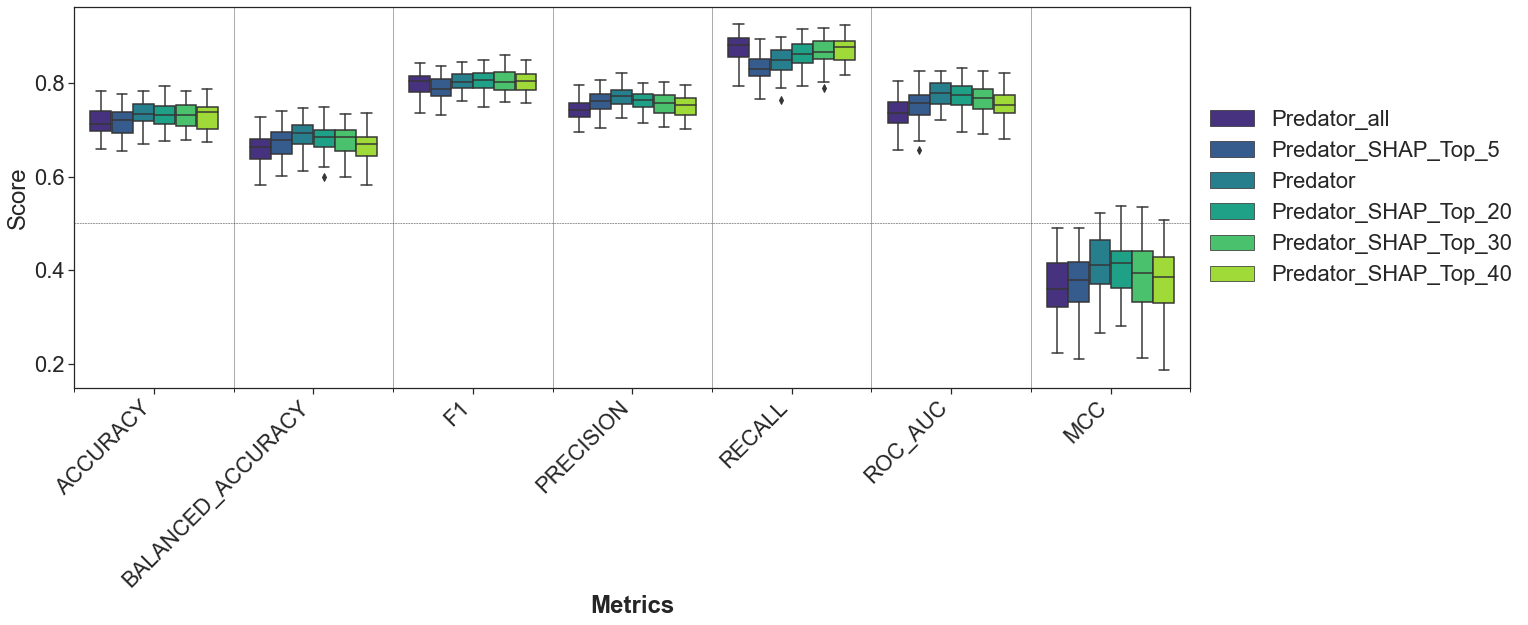

In [65]:
# metrics = ["BALANCED_ACCURACY", "F1"]
metrics = ["ACCURACY", "BALANCED_ACCURACY", "F1", "PRECISION", "RECALL", "ROC_AUC", "MCC"]
plot_performance_comparison_results(
    scoring_metrics_data_melted=scoring_metrics_data_melted_predators_sorted,
    metrics=metrics,
    filename="supplementary_predator_all_metrics",
    palette_param="viridis",
    figsize=(20, 7),
    export=False,
    overwrite=False,
    # title=r"Performance\ Comparison\ of\ Predator"
)

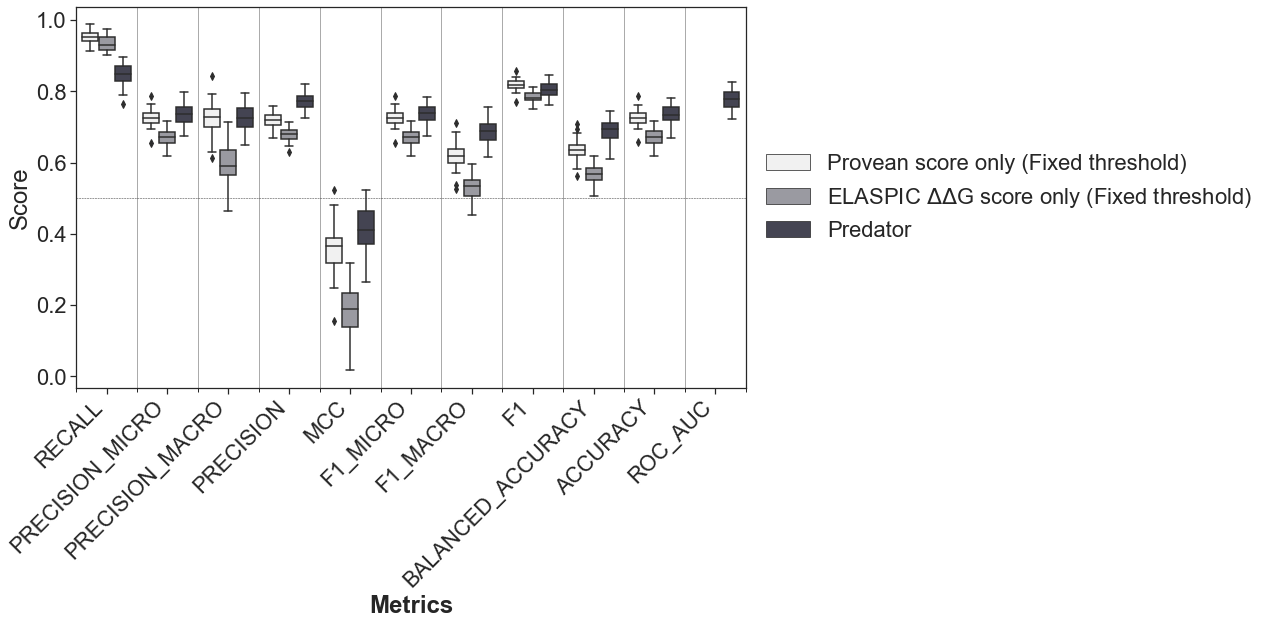

In [66]:
metrics = list(scoring_metrics_data_melted_predator_vs_single_features_sorted["METRIC"].unique())
plot_performance_comparison_results(
    scoring_metrics_data_melted=scoring_metrics_data_melted_predator_vs_single_features_sorted,
    metrics=metrics,
    filename="performance_comparison_provean-ddg-predator",
    palette_param="light:#444452",
    figsize=(12, 7),
    export=False,
    overwrite=False
)

metrics=['RECALL', 'PRECISION', 'F1', 'BALANCED_ACCURACY', 'ACCURACY']


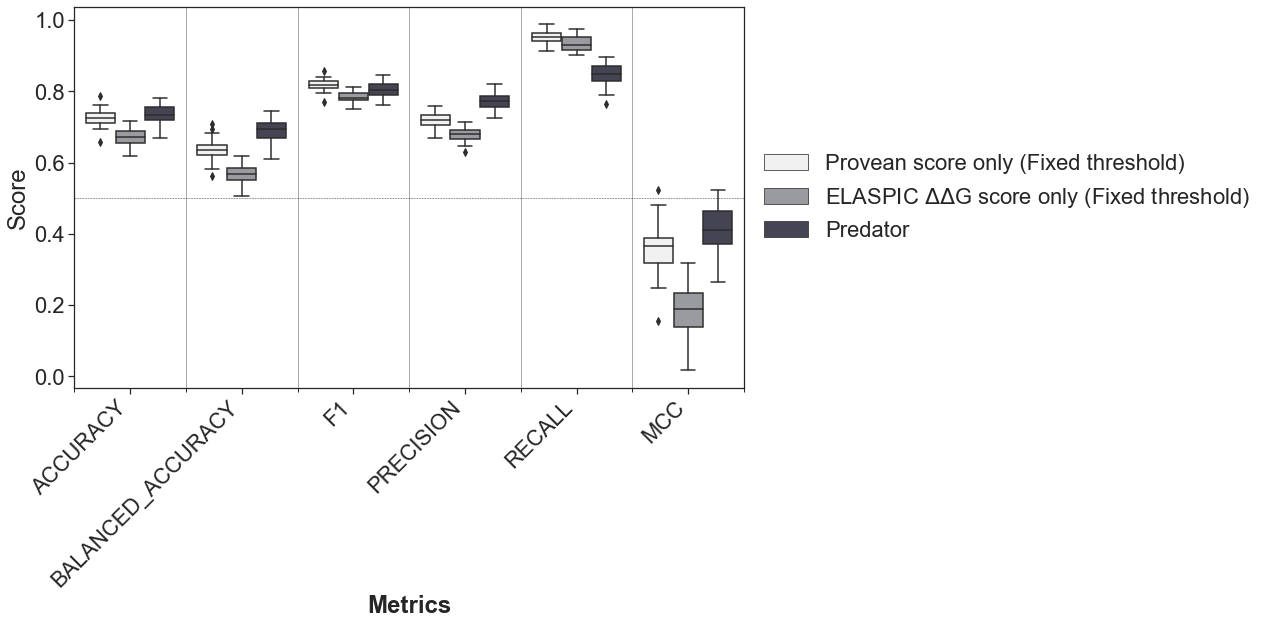

In [67]:
metrics = [
    metric for metric in list(
        scoring_metrics_data_melted_predator_vs_single_features_sorted["METRIC"].unique()
    ) if metric not in [
        "MCC", "ROC_AUC", "PRECISION_MICRO", "PRECISION_MACRO", "F1_MICRO", "F1_MACRO"
    ]
]

print(f"{metrics=}")

metrics = ["ACCURACY", "BALANCED_ACCURACY", "F1", "PRECISION", "RECALL", "MCC"]

plot_performance_comparison_results(
    scoring_metrics_data_melted=scoring_metrics_data_melted_predator_vs_single_features_sorted,
    metrics=metrics,
    filename="performance_comparison_provean-ddg-predator",
    palette_param="light:#444452",
    figsize=(12, 7),
    export=False,
    overwrite=False
)

metrics=['RECALL', 'PRECISION', 'F1', 'BALANCED_ACCURACY', 'ACCURACY']


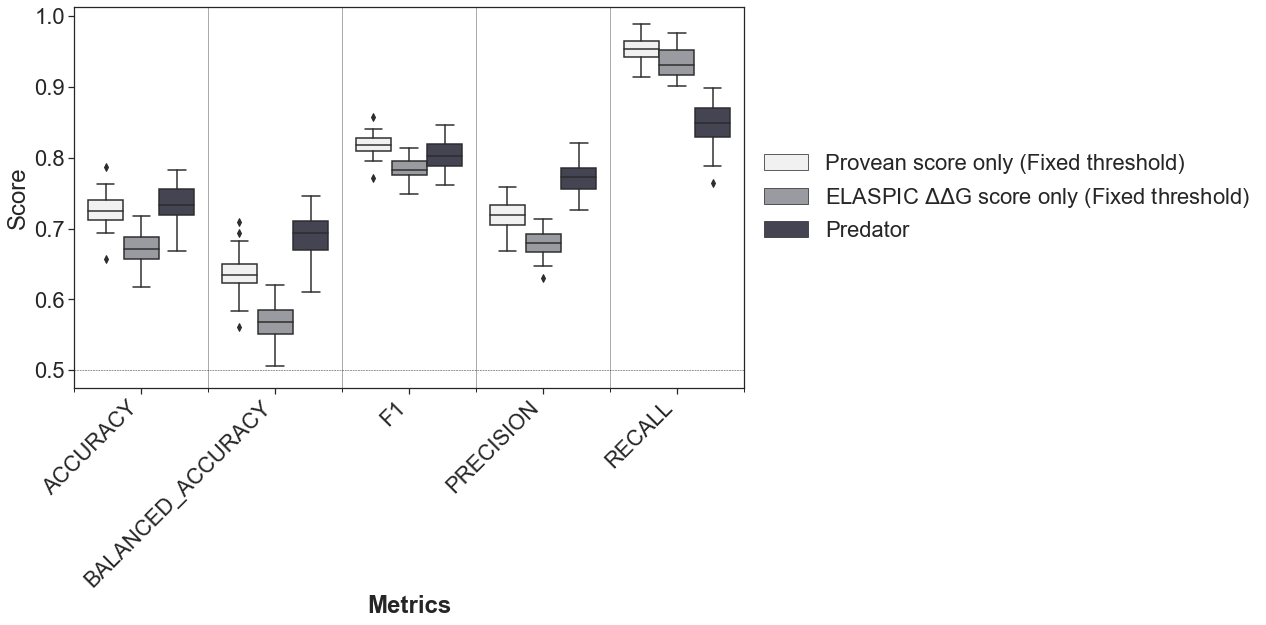

In [68]:
metrics = [
    metric for metric in list(
        scoring_metrics_data_melted_predator_vs_single_features_sorted["METRIC"].unique()
    ) if metric not in [
        "MCC", "ROC_AUC", "PRECISION_MICRO", "PRECISION_MACRO", "F1_MICRO", "F1_MACRO"
    ]
]

print(f"{metrics=}")

metrics = ["ACCURACY", "BALANCED_ACCURACY", "F1", "PRECISION", "RECALL"]

plot_performance_comparison_results(
    scoring_metrics_data_melted=scoring_metrics_data_melted_predator_vs_single_features_sorted,
    metrics=metrics,
    filename="performance_comparison_provean-ddg-predator",
    palette_param="light:#444452",
    figsize=(12, 7),
    export=False,
    overwrite=False
)

In [ ]:
"""
default' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'
"""